In [1]:
import sys
import os


project_root = os.path.abspath(os.path.join('..', r'C:\Users\Calin PC\Documents\Proiecte\linux_monitoring_project\helper'))  
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import LocalOutlierFactor
import dbconnector, etl

In [3]:
def eval_metrics(actual, pred):
    accuracy = round(accuracy_score(actual, pred), 2)
    fiscore = round(f1_score(actual, pred, average='macro'), 2)
    return accuracy, fiscore

In [4]:
def classification_report_df(class_report):
    class_report_list = []
    for item in class_report.split('\n'):
        if item:
            class_report_list.append([i.strip() for i in item.strip().split() if i])
    class_report_list[0].insert(0, 'class')
    class_report_list[0].insert(0, '')
    for item in class_report_list[1:len(class_report_list)-3]:
        item.insert(0, '')
    df = pd.DataFrame(class_report_list[1:], columns=class_report_list[0])
    return df

In [5]:
db = dbconnector.Connect(
    "SELECT * FROM public.records",
    r"C:\Users\Calin PC\Documents\Proiecte\linux_monitoring_project\data\config.txt",
    which_database="POSTGRESQL",
)
linux_records = db.dbconnector()
linux_records = etl.Transformer.to_datetime(linux_records, "record_timestamp")
linux_records = etl.Transformer.drop_negative(linux_records, "idle")
linux_records = etl.Transformer.drop_constants(
    linux_records, ["devtmpfs", "irq", "steal", "guest", "mem_total", "swap_total"]
)

Successfully connected to the database on host: localhost


C:\Users\Calin PC\Documents\Proiecte\linux_monitoring_project\helper\dbconnector.py:67: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql=self.sql_query, con=conn)


# 68–95–99.7 Empirical Rule

In [6]:
linux_records['sys_diff'] = linux_records['sys'].diff().fillna(0)
mean_diff = linux_records['sys_diff'].mean()
std_diff = linux_records['sys_diff'].std()
anomaly_threshold = mean_diff + 2 * std_diff
linux_records['sys_diff_threshold_ratio'] = linux_records['sys_diff'] / anomaly_threshold
linux_records['sys_diff_mean_ratio'] = linux_records['sys_diff'] / mean_diff
# linux_records['sys_anomaly'] = np.where(linux_records['sys_diff'] > anomaly_threshold, -1, 1)
linux_records['anomaly'] = np.where(linux_records['sys_diff'] > anomaly_threshold, -1, 1)

In [7]:
# linux_records['mem_used_diff'] = linux_records['mem_used'].diff().fillna(0)
# mean_diff = linux_records['mem_used_diff'].mean()
# std_diff = linux_records['mem_used_diff'].std()
# anomaly_threshold = mean_diff + 2 * std_diff
# linux_records['mem_used_anomaly'] = np.where(linux_records['mem_used_diff'] > anomaly_threshold, -1, 1)

In [8]:
# linux_records['anomaly'] = np.where((linux_records['sys_anomaly'] == -1) | (linux_records['mem_used_anomaly'] == -1), -1, 1)
# linux_records

In [9]:
# features = ['sda1', 'cs_root', 'usr', 'sys', 'mem_used', 'idle']
features = ['sys', 'sys_diff', 'sys_diff_mean_ratio','sys_diff_threshold_ratio', 'usr', 'sda1']
X = linux_records[features]
y = linux_records['anomaly']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test = np.split(X, [int(.67*len(X))])
y_train, y_test = np.split(y, [int(.67*len(y))])

c:\Users\Calin PC\Documents\Proiecte\linux_monitoring_project\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Calin PC\Documents\Proiecte\linux_monitoring_project\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [10]:
params = {
    'n_neighbors': 20,
    'algorithm': 'auto',
    'leaf_size': 30,
    'metric': 'minkowski',
    'p': 2,
    'contamination': float(np.sum(y == -1) / len(y)),

}
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=float(np.sum(y == -1) / len(y))) # specificați parametrii doriti
lof_model.fit(X_train)


LocalOutlierFactor(contamination=0.03928775491122908)

In [11]:
params = {
    'n_estimators': 100,
    'max_samples': 'auto',
    'contamination': float(np.sum(y == -1) / len(y)),
    'random_state': 42
}
model = IsolationForest(**params)
model.fit(X_train)

IsolationForest(contamination=0.03928775491122908, random_state=42)

In [12]:
y_pred_train_lof = lof_model.fit_predict(X_train)
y_pred_test_lof = lof_model.fit_predict(X_test)

In [13]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [14]:
train_accuracy, train_fiscore = eval_metrics(y_train, y_pred_train)
test_accuracy, test_fiscore = eval_metrics(y_test, y_pred_test)
print(f'Train Accuracy: {train_accuracy}, F1 Score: {train_fiscore}')
print(f'Test Accuracy: {test_accuracy}, F1 Score: {test_fiscore}')

Train Accuracy: 0.96, F1 Score: 0.76
Test Accuracy: 0.96, F1 Score: 0.76


In [15]:
train_accuracy_lof, train_fiscore_lof = eval_metrics(y_train, y_pred_train_lof)
test_accuracy_lof, test_fiscore_lof = eval_metrics(y_test, y_pred_test_lof)
print(f'Train Accuracy LOF: {train_accuracy_lof}, F1 Score: {train_fiscore_lof}')
print(f'Test Accuracy LOF: {test_accuracy_lof}, F1 Score: {test_fiscore_lof}')

Train Accuracy LOF: 0.93, F1 Score: 0.55
Test Accuracy LOF: 0.93, F1 Score: 0.52


In [16]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          -1       0.54      0.54      0.54      6129
           1       0.98      0.98      0.98    152699

    accuracy                           0.96    158828
   macro avg       0.76      0.76      0.76    158828
weighted avg       0.96      0.96      0.96    158828



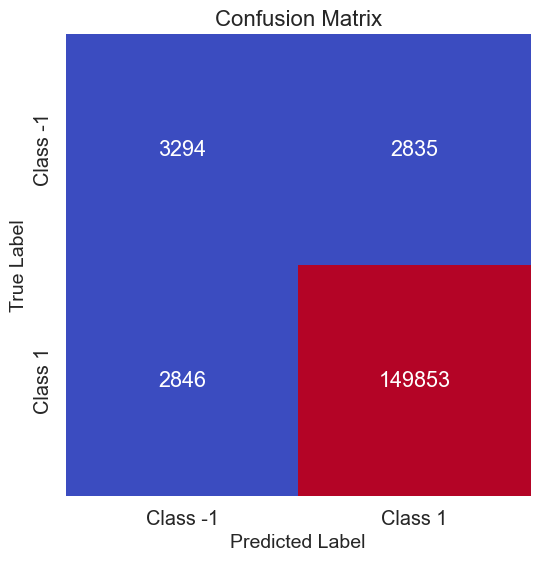

In [17]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6, 6))
sns.set_theme(font_scale=1.3)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False,
            xticklabels=['Class -1', 'Class 1'],
            yticklabels=['Class -1', 'Class 1'])

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

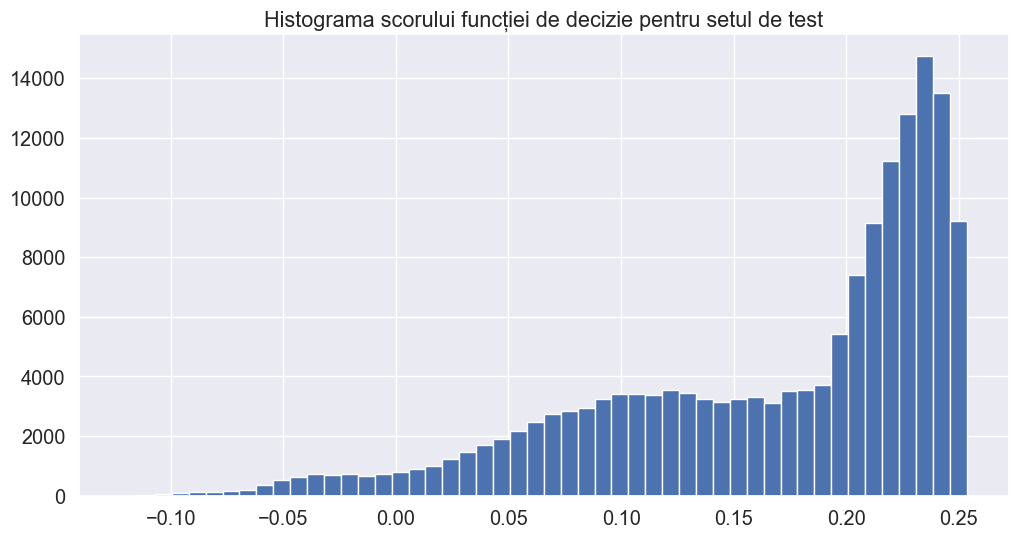

In [18]:
plt.figure(figsize=(12, 6))
plt.hist(model.decision_function(X_test), bins=50)
plt.title('Histograma scorului funcției de decizie pentru setul de test')
plt.show()

In [19]:
y_pred_test

array([1, 1, 1, ..., 1, 1, 1])